In [10]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2

In [11]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [12]:
#Creating the Landmark object
base_options = python.BaseOptions(model_asset_path='../models/pose_landmarker_heavy.task')
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
    running_mode=vision.RunningMode.VIDEO,
    min_pose_detection_confidence=0.6,
    min_pose_presence_confidence=0.7,
    min_tracking_confidence=0.95,
)
detector = vision.PoseLandmarker.create_from_options(options)

In [13]:
VIDEO_PATH    = "../data/raw/video3.mp4"
OUTPUT_PATH   = "../data/processed/video3_annotated_new.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video file: {VIDEO_PATH}")

fps    = cap.get(cv2.CAP_PROP_FPS) or 30.0
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')              # or 'avc1', 'XVID', etc.
out    = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

keypoints = []
frame_idx = 0

while True:
    success, frame_bgr = cap.read()
    if not success:
        break
    
    frame_idx += 1
    
    frame_rgb  = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    mp_image   = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
    result     = detector.detect_for_video(mp_image, timestamp_ms)
    if not result.pose_landmarks:
        print(f"No pose landmarks detected in frame {frame_idx}")
        continue

    if result.pose_landmarks:
        lm = result.pose_landmarks[0]
        coords = np.array(
            [[l.x, l.y, l.z] for l in lm],
            dtype=np.float32
        )
    else:
        coords = np.zeros((len(solutions.pose.PoseLandmark), 3), dtype=np.float32)

    keypoints.append(coords)

    annotated_rgb = draw_landmarks_on_image(frame_rgb, result)
    annotated_bgr = cv2.cvtColor(annotated_rgb, cv2.COLOR_RGB2BGR)

    out.write(annotated_bgr)

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Saved annotated video to {OUTPUT_PATH}")


Saved annotated video to ../data/processed/video3_annotated_new.mp4


# Phase Segmentation

In [14]:
import os

kp_array = np.stack(keypoints, axis=0)  # shape = (F, L, 3)
os.makedirs(os.path.dirname("D:/Projects/TrueForm/data/keypoints"), exist_ok=True)
np.save("D:/Projects/TrueForm/data/keypoints/video3_landmarks.npy", kp_array)
print(f"Saved landmarks array to {'D:/Projects/TrueForm/data/keypoints/video3_landmarks.npy'}")

Saved landmarks array to D:/Projects/TrueForm/data/keypoints/video3_landmarks.npy


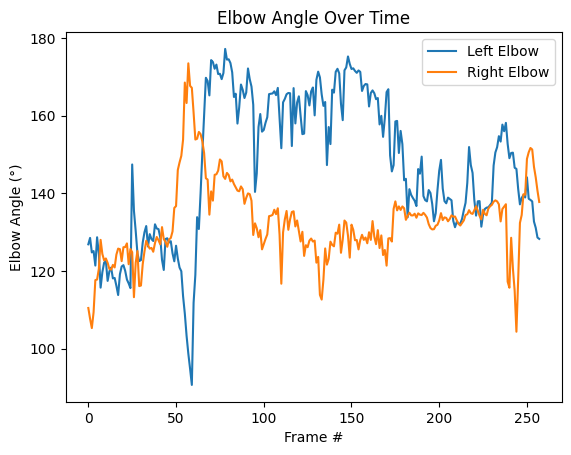

In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt


def angle_between(a, b, c):
    ba = a - b
    bc = c - b
    cos_ang = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return math.degrees(math.acos(np.clip(cos_ang, -1.0, 1.0)))

landmarks = np.load('../data/keypoints/video_2_landmarks.npy')  # shape (F,33,3)
F = landmarks.shape[0]

# Preallocating arrays for angles
left_elbow = np.zeros(F)
right_elbow = np.zeros(F)


L = solutions.pose.PoseLandmark

for i in range(F):
    coords = landmarks[i]
    left_elbow[i]  = angle_between(
        coords[L.LEFT_SHOULDER.value],
        coords[L.LEFT_ELBOW.value],
        coords[L.LEFT_WRIST.value]
    )
    right_elbow[i] = angle_between(
        coords[L.RIGHT_SHOULDER.value],
        coords[L.RIGHT_ELBOW.value],
        coords[L.RIGHT_WRIST.value]
    )

# Plot
plt.figure()
plt.plot(range(F), left_elbow, label='Left Elbow')
plt.plot(range(F), right_elbow, label='Right Elbow')
plt.xlabel('Frame #')
plt.ylabel('Elbow Angle (°)')
plt.title('Elbow Angle Over Time')
plt.legend()
plt.show()